# Albedo

The objective of this script is to calculate the albedo of the desert background of the Yatir forest based on the truck measurements of Auguts 2013 and 2015.

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars
import scipy.stats
from scipy import signal
from scipy import stats

### Input and output paths

In [2]:
project_path = 'D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/'   # Weizmann desktop
#project_path = 'C:/Users/rafas/Dropbox/Doutorado/Working/Ketura/'     # notebook
input_path   = project_path + '01_data/'
output_path  = project_path + '02_output/'
graphs_path  = project_path + '03_graphs/'

## Functions

In [17]:
# Loads all data in the folder
def load_all_data(path):
    file_list = sorted(glob.glob(path + '*Yatir Desert*.csv', recursive=True))

    data_list = []
    for filename in file_list:
        fn_without_path = filename.replace(path[:-1], "")[1:]
        print("Loading", fn_without_path)
        
        temp = pd.read_csv(filename)
        # attribute Season and Ecosystem
        temp['Ecosystem'] = fn_without_path.split(' ')[2]
        temp['Year'] = fn_without_path.split(' ')[5]
        temp['Month'] = fn_without_path.split(' ')[4]
        temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
        
        temp.loc[temp['Month'] == 'July', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'August', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'September', 'Season'] = 'Summer'
        temp.loc[temp['Ecosystem'] == 'Yatir', 'Ecosystem'] = 'Desert background'
        
        data_list.append(temp)
        
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    
    # Rename
    df.rename(columns={'SW_OUT_average': 'Sout'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'Sin'}, inplace=True)
    df.rename(columns={'PPFD_IN_0_0_1': 'PARin'}, inplace=True)
    df.rename(columns={'PPFD_OUT_0_0_1': 'PARout'}, inplace=True)

       
    # Convert columns to float
    df['Sout']  = pd.to_numeric(df['Sout'], downcast="float")
    df['Sin']  = pd.to_numeric(df['Sin'], downcast="float")
    df['PARout']  = pd.to_numeric(df['PARout'], downcast="float")
    df['PARin']  = pd.to_numeric(df['PARin'], downcast="float")
    
    df['albedo'] = df['Sout']/df['Sin']
    df['albedo_PAR'] = df['PARout']/df['PARin']
    
    # define mid-day
    #df = df.loc[(df['DateTime'].dt.hour >= 10) & (df['DateTime'].dt.hour < 15)].copy() 
    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','Sin','Sout','albedo','albedo_PAR']]
    

    return(df)


def diurnal(temp):
    temp = temp.copy()
    
    # creating 'Time' column
    temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    # Keep only relevant columns
    temp = temp[['Time','Ecosystem','Season','albedo']]
    
    # Make mean and std dev
    df_grouped = temp.groupby(['Ecosystem','Season','Time']).agg(['mean','std']).reset_index()
    df_grouped.columns = ['_'.join(col).strip('_') for col in df_grouped.columns.values]
    
    return(df_grouped)




def albedo_seasonal(temp):
    
    # define mid-day
    temp = temp.loc[(temp['DateTime'].dt.hour >= 10) & (temp['DateTime'].dt.hour < 15)].copy() 

    # Make mean and std dev
    df_means = temp.groupby(['Ecosystem','Season',]).mean().reset_index()
    df_sds   = temp.groupby(['Ecosystem','Season',]).std().reset_index()
    # rename columns
    df_means.rename(columns={'albedo': 'albedo_mean'}, inplace=True)
    df_means.rename(columns={'albedo_PAR': 'albedo_PAR_mean'}, inplace=True)
    
    df_sds.rename(columns={'albedo': 'albedo_sd'}, inplace=True)
    df_sds.rename(columns={'albedo_PAR': 'albedo_PAR_sd'}, inplace=True)
    
    merged = df_means.merge(df_sds, on=['Ecosystem','Season'])
    
    # Keep only relevant columns
    merged = merged[['Season','Ecosystem','albedo_mean','albedo_sd','albedo_PAR_mean','albedo_PAR_sd']]    
    
    return(merged)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

def load_tower(fn, silent=False):
    if (not silent): print('EC Tower')
    temp = pd.read_csv(fn, index_col=None)
    temp.rename({'date_mid_hour': 'DateTime'}, axis=1, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%d%b%y:%H:%M', utc=True)
    # Remove obsolete columns
    temp.drop(['year','date','DOY','month','weekNo','mid_hour','mmyy','Bat_V','Hum_AC'], axis=1, inplace=True)
    if (not silent): print("    ", '100.0 %\t', fn.split('/')[-1])
    return(temp)

In [21]:
df = load_all_data(input_path)

display (df)

Loading Rafael Yatir Yatir Desert August 2013 storagek analysis SWLWcorr.csv
Loading Rafael Yatir Yatir Desert August 2015 storagek analysis SWLWcorr.csv


,DateTime,Season,Year,Ecosystem,Sin,Sout,albedo,albedo_PAR
0,2013-08-21 14:30:00+00:00,Summer,2013,Desert background,699.809998,235.565002,0.336613,0.291679
1,2013-08-21 15:00:00+00:00,Summer,2013,Desert background,609.671021,209.255997,0.343228,0.301829
2,2013-08-21 15:30:00+00:00,Summer,2013,Desert background,501.877991,175.016006,0.348722,0.310958
3,2013-08-21 16:00:00+00:00,Summer,2013,Desert background,392.372009,138.619995,0.353287,0.319158
4,2013-08-21 16:30:00+00:00,Summer,2013,Desert background,275.833008,99.534698,0.360851,0.325573
...,...,...,...,...,...,...,...,...
1026,2015-08-29 23:00:00+00:00,Summer,2015,Desert background,0.000000,0.039696,inf,0.646236
1027,2015-08-29 23:30:00+00:00,Summer,2015,Desert background,0.000000,0.016154,inf,0.683375
1028,2015-08-30 00:00:00+00:00,Summer,2015,Desert background,0.000000,0.020428,inf,0.749138
1029,2015-08-30 00:30:00+00:00,Summer,2015,Desert background,0.000000,0.007482,inf,0.788478


In [22]:
diurnal_cycle_df = diurnal(df)
# re-order categories
#diurnal_cycle_df['Season'] = pd.Categorical(diurnal_cycle_df['Season'], ordered=True, categories=['Spring','Summer','Autumn'])
diurnal_cycle_df.loc[~np.isfinite(diurnal_cycle_df['albedo_mean']), 'albedo_mean'] = 0
diurnal_cycle_df.loc[(diurnal_cycle_df['albedo_mean']) > 1, 'albedo_mean'] = 0
diurnal_cycle_df.loc[(diurnal_cycle_df['albedo_std']) > 1, 'albedo_std'] = 0

display (diurnal_cycle_df)

,Ecosystem,Season,Time,albedo_mean,albedo_std
0,Desert background,Summer,00:00,0.000000,NaN
1,Desert background,Summer,00:30,0.000000,NaN
2,Desert background,Summer,01:00,0.000000,NaN
3,Desert background,Summer,01:30,0.000000,NaN
4,Desert background,Summer,02:00,0.000000,NaN
5,Desert background,Summer,02:30,0.000000,NaN
6,Desert background,Summer,03:00,0.000000,NaN
7,Desert background,Summer,03:30,0.000000,NaN
8,Desert background,Summer,04:00,0.000000,NaN
9,Desert background,Summer,04:30,0.000000,NaN


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_diurnal.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_diurnal.png


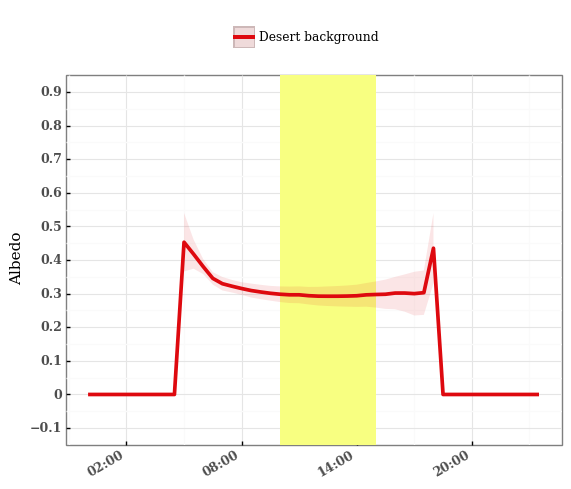

<ggplot: (-9223371979137095904)>

In [23]:
cbPalette = ["#DE090F","#2D09DE", "#DE090F", "#02000B", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
diurnal_cycle_df['timestamp2'] = pd.to_datetime(diurnal_cycle_df['Time'], utc=True)

plt = ggplot(diurnal_cycle_df)
plt = plt + geom_rect(mapping=aes(xmin=np.datetime64('2022-03-27 10:00'), xmax=np.datetime64('2022-03-27 15:00'), ymax=1, ymin=-0.2), size=0, fill='#F8FF81')
plt = plt + geom_line(aes(x='timestamp2', y='albedo_mean', color='Ecosystem'),size=1.5)
#plt = plt + geom_line(aes(x='timestamp2', y='LE_mean',linetype='Ecosystem'), colour='#234566')
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='albedo_mean - albedo_std', ymax='albedo_mean + albedo_std', fill='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='Albedo', parse=True)
#plt = plt + facet_wrap(['Ecosystem'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=1,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + coord_cartesian(ylim=(-0.1, 0.9))
plt = plt + scale_y_continuous(breaks=np.arange(-0.1, 1, 0.1))
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'albedo_diurnal.pdf', width=15, height=10, units='cm', dpi=600)
plt.save(graphs_path + 'albedo_diurnal.png', width=15, height=10, units='cm', dpi=600)


plt

# t-tests

In [25]:
df = df.loc[(df['DateTime'].dt.hour >= 10) & (df['DateTime'].dt.hour < 15)].copy() 

a = df.loc[(df['Ecosystem'] == 'Desert background'),'albedo']
b = df.loc[(df['Ecosystem'] == 'PV field'),'albedo']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('P =', t[1])
p_albedo = t[1]

P = nan


In [8]:
# a = spring_df.loc[(spring_df['Ecosystem'] == 'Desert background'),'albedo_PAR']
# b = spring_df.loc[(spring_df['Ecosystem'] == 'PV field'),'albedo_PAR']
# t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
# print('P =', t[1])

In [26]:
df_seasonal = albedo_seasonal(df)

display(df_seasonal)

,Season,Ecosystem,albedo_mean,albedo_sd,albedo_PAR_mean,albedo_PAR_sd
0,Summer,Desert background,0.294628,0.028338,0.239126,0.029307


## Loading Yatir data

In [11]:
yatir_df = load_tower(input_path + 'Yatir_2000-2020.csv')
yatir_df['Year'] = yatir_df['DateTime'].dt.year
#yatir_df = yatir_df.loc[(yatir_df['DateTime'].dt.year >= 2015)].copy()
yatir_df = yatir_df.dropna(subset = ['S_top_atm(CM21_IV)_Wm-2','S_top_eco(CM21_III)_Wm-2'])

# Rename
yatir_df.rename(columns={'S_top_atm(CM21_IV)_Wm-2': 'Sin'}, inplace=True)
yatir_df.rename(columns={'S_top_eco(CM21_III)_Wm-2': 'Sout'}, inplace=True)


# yatir_df['DateTime'] = pd.to_datetime(yatir_df['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)

# Convert columns to float
yatir_df['Sin']  = pd.to_numeric(yatir_df['Sin'], downcast='float')
yatir_df['Sout']  = pd.to_numeric(yatir_df['Sout'], downcast='float')

# Calculate albedo
yatir_df['albedo'] = yatir_df['Sout']/yatir_df['Sin']

# define mid-day
yatir_df = yatir_df.loc[(yatir_df['DateTime'].dt.hour >= 10) & (yatir_df['DateTime'].dt.hour < 15)].copy() 

yatir_df['Season'] = 'Spring'
yatir_df['Ecosystem'] = 'Yatir'


# Keep only relevant columns
yatir_df = yatir_df[['DateTime','Season','Year','Ecosystem','Sin','Sout','albedo']]


#print(yatir_df.columns.values)
display(yatir_df)

EC Tower


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.


     100.0 %	 Yatir_2000-2020.csv


,DateTime,Season,Year,Ecosystem,Sin,Sout,albedo
30788,2002-02-01 10:15:00+00:00,Spring,2002,Yatir,660.500000,80.900002,0.122483
30789,2002-02-01 10:45:00+00:00,Spring,2002,Yatir,719.000000,90.500000,0.125869
30790,2002-02-01 11:15:00+00:00,Spring,2002,Yatir,755.000000,95.500000,0.126490
30791,2002-02-01 11:45:00+00:00,Spring,2002,Yatir,775.000000,97.699997,0.126065
30792,2002-02-01 12:15:00+00:00,Spring,2002,Yatir,777.000000,98.500000,0.126770
...,...,...,...,...,...,...,...
357961,2020-09-30 12:45:00+00:00,Spring,2020,Yatir,787.299988,92.000000,0.116855
357962,2020-09-30 13:15:00+00:00,Spring,2020,Yatir,741.299988,85.599998,0.115473
357963,2020-09-30 13:45:00+00:00,Spring,2020,Yatir,669.500000,77.900002,0.116355
357964,2020-09-30 14:15:00+00:00,Spring,2020,Yatir,588.400024,70.099998,0.119137


In [12]:
temp = yatir_df.copy()
temp['DateTime'] = temp['DateTime'] - pd.Timedelta(minutes=15)

all_df = pd.concat([spring_df, yatir_df])

#display(all_df)

print('Mean albedo Yatir: ', np.round(np.mean(all_df.loc[all_df['Ecosystem'] == 'Yatir', 'albedo']),2), '±', np.round(np.std(all_df.loc[all_df['Ecosystem'] == 'Yatir', 'albedo']),2))
print('Mean albedo PV:    ', np.round(np.mean(all_df.loc[all_df['Ecosystem'] == 'PV field', 'albedo']),2), '±', np.round(np.std(all_df.loc[all_df['Ecosystem'] == 'PV field', 'albedo']),2))
print('Mean albedo desert:', np.round(np.mean(all_df.loc[all_df['Ecosystem'] == 'Desert background', 'albedo']),2), '±', np.round(np.std(all_df.loc[all_df['Ecosystem'] == 'Desert background', 'albedo']),2))



Mean albedo Yatir:  0.12 ± 0.01
Mean albedo PV:     0.23 ± 0.01
Mean albedo desert: 0.4 ± 0.0


# Graph

C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_ketura_yatir.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_ketura_yatir.png


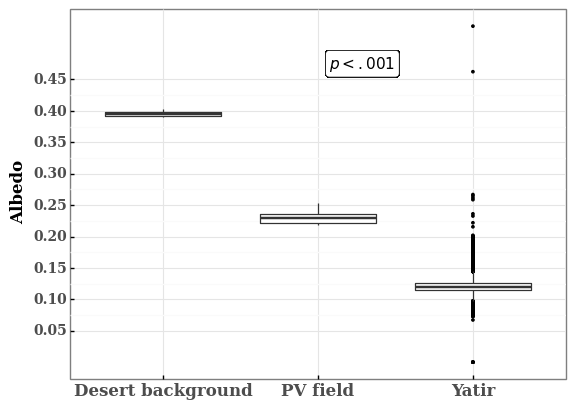

<ggplot: (-9223372007840323212)>

In [13]:
plt = ggplot(all_df)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='Ecosystem', y='albedo'), outlier_color='black', outlier_size=0.5)
plt = plt + labs(x='', y='Albedo', parse=True)
plt = plt + scale_y_continuous(breaks=np.arange(0.05, 0.5, 0.05))
plt = plt + theme(axis_text_x=element_text(size=12,rotation = 0, hjust=0.5,weight='bold'),
                  axis_text_y=element_text(size=10,weight='bold'),
                  axis_title_y=element_text(size=12,weight='bold'),
                  strip_text=element_text(size=12,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')


p_text = '$p' + pvalue_text(p_albedo) + '$'
plt = plt + geom_label(aes(x=2.5, y=0.475, label='p_text'), ha='right', parse=False, label_size=0.5)

plt.save(graphs_path + 'albedo_ketura_yatir.pdf', width=15, height=10, units='cm', dpi=600)
plt.save(graphs_path + 'albedo_ketura_yatir.png', width=15, height=10, units='cm', dpi=600)
plt

,DateTime,Season,Year,Ecosystem,Sin,Sout,albedo,albedo_PAR
317,2018-03-19 10:00:00+00:00,Spring,2018,Desert background,852.382019,339.255005,0.398008,0.346990
318,2018-03-19 10:30:00+00:00,Spring,2018,Desert background,905.132996,358.729004,0.396327,0.341564
319,2018-03-19 11:00:00+00:00,Spring,2018,Desert background,940.831970,372.403992,0.395824,0.338099
320,2018-03-19 11:30:00+00:00,Spring,2018,Desert background,958.448975,380.694000,0.397198,0.337656
321,2018-03-19 12:00:00+00:00,Spring,2018,Desert background,954.275024,377.213989,0.395289,0.338685
...,...,...,...,...,...,...,...,...
1463,2018-03-27 12:30:00+00:00,Spring,2018,PV field,411.884003,103.889999,0.252231,0.226692
1464,2018-03-27 13:00:00+00:00,Spring,2018,PV field,341.119995,85.648201,0.251079,0.229226
1465,2018-03-27 13:30:00+00:00,Spring,2018,PV field,305.093994,77.101501,0.252714,0.228437
1466,2018-03-27 14:00:00+00:00,Spring,2018,PV field,209.371002,52.897598,0.252650,0.232436


,DateTime,Season,Year,Ecosystem,Sin,Sout,albedo,albedo_PAR
317,2018-03-19 10:00:00+00:00,Spring,2018,Desert background,852.382019,339.255005,0.398008,0.346990
318,2018-03-19 10:30:00+00:00,Spring,2018,Desert background,905.132996,358.729004,0.396327,0.341564
319,2018-03-19 11:00:00+00:00,Spring,2018,Desert background,940.831970,372.403992,0.395824,0.338099
320,2018-03-19 11:30:00+00:00,Spring,2018,Desert background,958.448975,380.694000,0.397198,0.337656
321,2018-03-19 12:00:00+00:00,Spring,2018,Desert background,954.275024,377.213989,0.395289,0.338685
322,2018-03-19 12:30:00+00:00,Spring,2018,Desert background,933.966003,367.263000,0.393230,0.338476
323,2018-03-19 13:00:00+00:00,Spring,2018,Desert background,892.216980,349.984009,0.392263,0.340402
324,2018-03-19 13:30:00+00:00,Spring,2018,Desert background,834.244019,326.876007,0.391823,0.344205
325,2018-03-19 14:00:00+00:00,Spring,2018,Desert background,752.883972,294.880005,0.391667,0.348492
326,2018-03-19 14:30:00+00:00,Spring,2018,Desert background,664.375000,259.649994,0.390818,0.352693


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_ketura.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/albedo_ketura.png


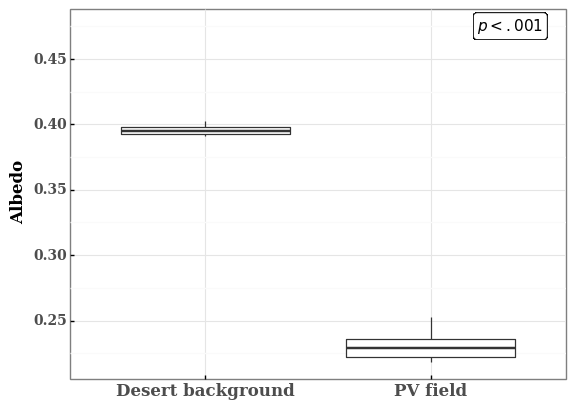

<ggplot: (-9223371991610674592)>

In [69]:
#long_df.dropna(subset=['type'], inplace=True)

# define mid-day
#spring_df = spring_df.loc[(spring_df['DateTime'].dt.hour >= 10) & (spring_df['DateTime'].dt.hour < 15) & (spring_df['DateTime'].dt.day != 22)].copy() 
#spring_df = spring_df.loc[(spring_df['DateTime'].dt.hour >= 10) & (spring_df['DateTime'].dt.hour < 15)].copy() 
    
display(spring_df)

display(spring_df.loc[spring_df['Ecosystem'] == 'Desert background'])

plt = ggplot(spring_df)
plt = plt + theme_bw()
plt = plt + geom_boxplot(aes(x='Ecosystem', y='albedo'), outlier_color='black', outlier_size=0.5)
plt = plt + labs(x='', y='Albedo', parse=True)
plt = plt + scale_y_continuous(breaks=np.arange(0.2, 0.5, 0.05))
plt = plt + theme(axis_text_x=element_text(size=12,rotation = 0, hjust=0.5,weight='bold'),
                  axis_text_y=element_text(size=10,weight='bold'),
                  axis_title_y=element_text(size=12,weight='bold'),
                  strip_text=element_text(size=12,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')


p_text = '$p' + pvalue_text(p_albedo) + '$'
plt = plt + geom_label(aes(x=2.5, y=0.475, label='p_text'), ha='right', parse=False, label_size=0.5)

plt.save(graphs_path + 'albedo_ketura.pdf', width=15, height=10, units='cm', dpi=600)
plt.save(graphs_path + 'albedo_ketura.png', width=15, height=10, units='cm', dpi=600)
plt